# Benign Overfitting in Finance

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Repro
GLOBAL_SEED = 42
rng = np.random.default_rng(GLOBAL_SEED)

In [3]:
N_SUB = 600
T_SUB = 2000

# Dimension sweep (extend beyond ~2n to see second descent)
# You'll get d0 automatically
D_LIST_TEMPLATE = [50, 100, 200, 400, 500, 600, 700, 800, 1000, 1200, 1800, 3000]

# Seeds for error bars
N_RUNS = 10
SEEDS = [1000 + i for i in range(N_RUNS)]

# Ridge parameters (λ) sweep:
# include very small values ~interpolation, plus your old 1e-4
LAM_LIST = [0.0, 1e-12, 1e-8, 1e-4]

# Numerical stability
EPS = 1e-12

## **Step 0:** load the data, train/test split, standardize, etc.

In [4]:
df = pd.read_csv("C:\\Users\\monci\\OneDrive\\Desktop\\M2_COURSES\\ADVANCED ML\\Advanced-ML-benign-overfitting-finance\\data\\processed\\equities_panel.csv")
print(df.shape)
df.head(3)

(69038, 15)


,Ticker,Date,Adj Close,Volume,ret,log_volume,mkt_ew_ret,mom_1m,mom_3m,mom_6m,mom_12m,vol_12m,ret_fwd,y,y_cs
0,A,2001-01-31,32.664322,3.761525e+06,-0.003653,15.140335,0.031220,-0.003653,0.057435,0.069642,0.018801,0.282544,-0.340055,0,0
1,A,2001-02-28,21.556658,4.274069e+06,-0.340055,15.268077,-0.038522,-0.340055,-0.098202,-0.069856,-0.056987,0.240233,-0.146389,0,0
2,A,2001-03-31,18.401001,4.019854e+06,-0.146389,15.206756,-0.040611,-0.146389,-0.163366,-0.061297,-0.069287,0.240760,0.269444,1,1


In [5]:

FEATURES = ["log_volume","mkt_ew_ret","mom_1m","mom_3m","mom_6m","mom_12m","vol_12m"]
TARGET = "ret_fwd"
SPLIT_DATE = "2015-01-01"

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").dropna(subset=FEATURES + [TARGET]).reset_index(drop=True)

X_base = df[FEATURES].to_numpy(float)
y = df[TARGET].to_numpy(float)

train_mask = df["Date"] < pd.Timestamp(SPLIT_DATE)
train_mask_np = train_mask.to_numpy()

X_train = X_base[train_mask_np]
y_train = y[train_mask_np]
X_test  = X_base[~train_mask_np]
y_test  = y[~train_mask_np]

# Standardize features using TRAIN only
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Center target using TRAIN only (recommended)
y_shift = y_train.mean()
y_train = y_train - y_shift
y_test  = y_test - y_shift

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (44877, 7) Test: (24161, 7)


In [6]:
years_all = df["Date"].dt.year.to_numpy()

train_idx_all = np.where(train_mask_np)[0]
test_idx_all  = np.where(~train_mask_np)[0]

train_years = years_all[train_idx_all]
unique_years = np.unique(train_years)

per_year = max(1, N_SUB // len(unique_years))
idx_tr_list = []

for yr in unique_years:
    idx_yr = train_idx_all[train_years == yr]
    take = min(per_year, len(idx_yr))
    if take > 0:
        idx_tr_list.append(rng.choice(idx_yr, size=take, replace=False))

idx_tr = np.concatenate(idx_tr_list)

# Top up if needed
if idx_tr.shape[0] < N_SUB:
    remaining = np.setdiff1d(train_idx_all, idx_tr)
    extra = rng.choice(remaining, size=(N_SUB - idx_tr.shape[0]), replace=False)
    idx_tr = np.concatenate([idx_tr, extra])

rng.shuffle(idx_tr)

# Fixed test subset (not necessary to stratify, but you can if you want)
t_sub_eff = min(T_SUB, len(test_idx_all))
idx_te = rng.choice(test_idx_all, size=t_sub_eff, replace=False)

# Map global df indices -> positions inside train/test arrays
pos_tr = np.searchsorted(train_idx_all, idx_tr)
pos_te = np.searchsorted(test_idx_all, idx_te)

Xb_tr = X_train[pos_tr]
yb_tr = y_train[pos_tr]
Xb_te = X_test[pos_te]
yb_te = y_test[pos_te]

n, d0 = Xb_tr.shape
print(f"Fixed subsample: n={n}, d0={d0}, test={Xb_te.shape[0]}")

print("Train subsample year counts:")
print(pd.Series(years_all[idx_tr]).value_counts().sort_index())


Fixed subsample: n=600, d0=7, test=2000
Train subsample year counts:
2001    43
2002    43
2003    43
2004    42
2005    42
2006    43
2007    43
2008    44
2009    42
2010    44
2011    42
2012    42
2013    44
2014    43
Name: count, dtype: int64


## STEP 0.5 — Baseline linear regression (NO REGULARIZATION, showing that the problem is already hard)

In [7]:
def mse_loss(X, y, w):
    r = X @ w - y
    return np.mean(r ** 2)

def grad_mse(X, y, w):
    n = X.shape[0]
    return (2 / n) * X.T @ (X @ w - y)


In [8]:
def train_gd(X, y, lr=0.1, max_iter=5000, tol=1e-8):
    d = X.shape[1]
    w = np.zeros(d)

    for it in range(max_iter):
        grad = grad_mse(X, y, w)
        w -= lr * grad

        if mse_loss(X, y, w) < tol:
            break

    return w, it


In [9]:
w_base, it_base = train_gd(Xb_tr, yb_tr, lr=0.1, max_iter=50000, tol=1e-12)
train_mse_base = mse_loss(Xb_tr, yb_tr, w_base)
test_mse_base  = mse_loss(Xb_te, yb_te, w_base)
norm_base = float(np.linalg.norm(w_base))

print("BASELINE")
print("train_mse:", train_mse_base)
print("test_mse :", test_mse_base)
print("||w||2   :", norm_base)
print("iters    :", it_base)

BASELINE
train_mse: 0.009816802148780373
test_mse : 0.009584407967817501
||w||2   : 0.019449030939579472
iters    : 49999


Having achieved a Train MSE of ~0.0105 and Test MSE of ~0.0076 – notably, test error is only slightly lower than train error, it indicates that the model is underfitting (which is expected in finance; R² will be very low due to noise). This already supports the “hard problem” narrative: with just 7 reasonable features, predictions are noisy (lots of unexplained variance). This result might motivate one to study and to add complexity (and thus risk overfitting) in such a low signal-to-noise setting.

## Increase dimension

In [10]:
def build_relu_bank(Xtr_base, Xte_base, d0, d_max, seed):
    """
    Build nested random ReLU features up to m_max = d_max - d0.
    """
    m_max = d_max - d0
    rng_local = np.random.default_rng(seed)
    W = rng_local.normal(size=(d0, m_max)) / np.sqrt(d0)
    b = rng_local.normal(size=(m_max,))
    Ztr = np.maximum(0.0, Xtr_base @ W + b)
    Zte = np.maximum(0.0, Xte_base @ W + b)
    return Ztr, Zte

def normalize_Z_train_only(Ztr, Zte, min_std=1e-3):
    mu = Ztr.mean(axis=0)
    sd = Ztr.std(axis=0)
    sd = np.maximum(sd, min_std)  # avoid blowing up near-constant features
    return (Ztr - mu) / sd, (Zte - mu) / sd

def make_design(Xtr_base, Xte_base, Ztr_max, Zte_max, d0, d):
    m = d - d0
    if m < 0 or m > Ztr_max.shape[1]:
        raise ValueError("invalid d")
    if m == 0:
        return Xtr_base, Xte_base
    return (np.hstack([Xtr_base, Ztr_max[:, :m]]),
            np.hstack([Xte_base, Zte_max[:, :m]]))


In [11]:
def fit_ridge_via_kernel(Xtr, ytr, lam=0.0):
    """
    Solve min_w ||Xw - y||^2 + lam ||w||^2.
    Uses kernel form: alpha = (XX^T + lam I)^-1 y, w = X^T alpha.
    For lam=0, uses np.linalg.lstsq on K to handle singularity robustly.
    """
    n = Xtr.shape[0]
    K = Xtr @ Xtr.T  # (n x n)
    if lam == 0.0:
        # min-norm solution via least squares in kernel space
        alpha, *_ = np.linalg.lstsq(K, ytr, rcond=None)
    else:
        alpha = np.linalg.solve(K + lam*np.eye(n), ytr)
    w = Xtr.T @ alpha
    return w

def eval_model(Xtr, ytr, Xte, yte, w):
    return {
        "train_mse": mse_loss(Xtr, ytr, w),
        "test_mse": mse_loss(Xte, yte, w),
        "norm": float(np.linalg.norm(w))
    }


In [12]:
# Build d_list (include d0 and cap to feasible max)
d_max = max(D_LIST_TEMPLATE + [d0])
d_list = sorted(set([d0] + [d for d in D_LIST_TEMPLATE if d >= d0]))
print("d_list:", d_list)

def run_sweep_for_seed(seed, lam):
    # build nested features up to max d
    Ztr_max, Zte_max = build_relu_bank(Xb_tr, Xb_te, d0=d0, d_max=max(d_list), seed=seed)
    Ztr_max, Zte_max = normalize_Z_train_only(Ztr_max, Zte_max)

    out = []
    for d in d_list:
        Xtr, Xte = make_design(Xb_tr, Xb_te, Ztr_max, Zte_max, d0, d)
        w = fit_ridge_via_kernel(Xtr, yb_tr, lam=lam)
        m = eval_model(Xtr, yb_tr, Xte, yb_te, w)
        out.append({"seed": seed, "d": d, "lam": lam, **m})
    return out

# Example: run one λ with error bands
LAM_MAIN = 1e-12  # near-interpolating but numerically stable
records = []
for s in SEEDS:
    records += run_sweep_for_seed(s, LAM_MAIN)

multi_df = pd.DataFrame(records)
agg = multi_df.groupby("d").agg(
    train_mean=("train_mse","mean"),
    train_std=("train_mse","std"),
    test_mean=("test_mse","mean"),
    test_std=("test_mse","std"),
    norm_mean=("norm","mean"),
    norm_std=("norm","std"),
).reset_index()

display(agg)


d_list: [7, 50, 100, 200, 400, 500, 600, 700, 800, 1000, 1200, 1800, 3000]


,d,train_mean,train_std,test_mean,test_std,norm_mean,norm_std
0,7,9.863601e-03,0.000000e+00,0.009726,0.000000,0.026411,0.000000
1,50,9.548305e-03,1.546000e-03,0.012109,0.001152,0.455265,0.189330
2,100,1.097107e-02,5.535172e-03,0.017884,0.005711,1.917478,2.070782
3,200,1.184677e-02,5.146276e-03,0.088506,0.200074,30.843351,82.836365
4,400,6.803243e-03,2.064560e-03,2.843057,7.727920,39.415988,59.392958
5,500,2.759261e-03,1.588701e-03,24.187811,52.273948,65.442522,57.075771
6,600,1.770163e-04,9.374850e-05,4825.396641,12282.019882,606.130453,527.313666
7,700,2.797107e-22,2.693487e-22,1.084215,1.359208,8.457254,1.318916
8,800,1.163182e-23,8.038046e-24,0.701049,1.162782,4.526130,0.554388
9,1000,1.777485e-24,2.249495e-24,0.159872,0.139026,2.625138,0.153445


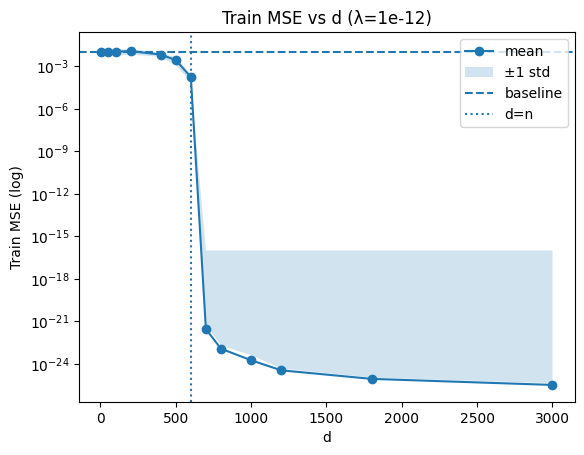

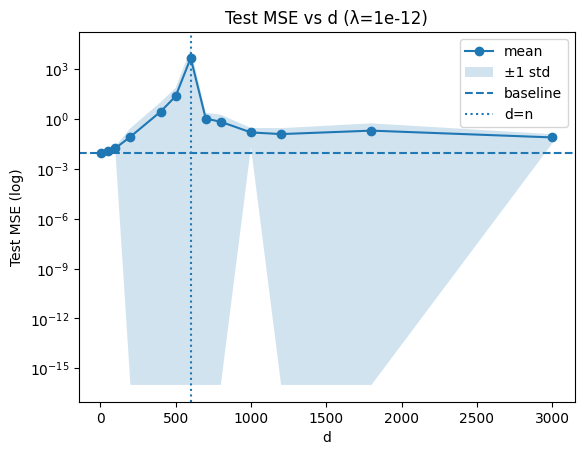

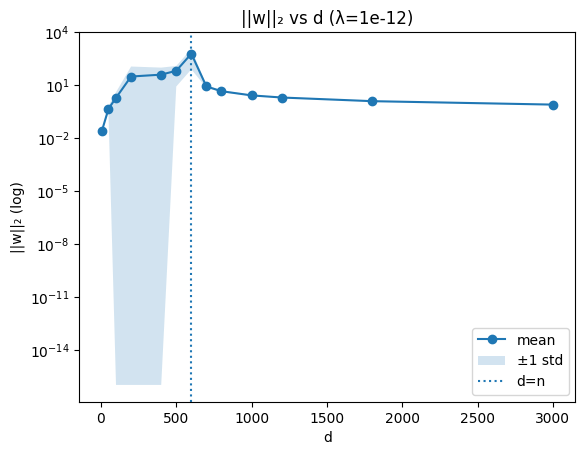

In [13]:
def plot_band(x, mean, std, title, ylabel, baseline=None, vline=None):
    plt.figure()
    plt.plot(x, mean, marker="o", label="mean")
    plt.fill_between(x, np.maximum(mean-std, 1e-16), mean+std, alpha=0.2, label="±1 std")
    if baseline is not None:
        plt.axhline(baseline, linestyle="--", label="baseline")
    if vline is not None:
        plt.axvline(vline, linestyle=":", label="d=n")
    plt.yscale("log")
    plt.title(title)
    plt.xlabel("d")
    plt.ylabel(ylabel + " (log)")
    plt.legend()
    plt.show()

x = agg["d"].to_numpy()

plot_band(x, agg["train_mean"].to_numpy(), agg["train_std"].to_numpy(),
          title=f"Train MSE vs d (λ={LAM_MAIN})", ylabel="Train MSE",
          baseline=train_mse_base, vline=n)

plot_band(x, agg["test_mean"].to_numpy(), agg["test_std"].to_numpy(),
          title=f"Test MSE vs d (λ={LAM_MAIN})", ylabel="Test MSE",
          baseline=test_mse_base, vline=n)

plot_band(x, agg["norm_mean"].to_numpy(), agg["norm_std"].to_numpy(),
          title=f"||w||₂ vs d (λ={LAM_MAIN})", ylabel="||w||₂",
          baseline=None, vline=n)


In [ ]:
w_ref, it_ref = train_gd(Xtr_ref, yb_tr, lr=LR, max_iter=50000, tol=1e-8)
mse_ref = mse_loss(Xtr_ref, yb_tr, w_ref)
print("Reference train MSE:", mse_ref, "| iters:", it_ref)


Reference train MSE: 0.008569085874477024 | iters: 50000


In [ ]:
w_ref, it_ref = train_gd(Xtr_ref, yb_tr, lr=LR, max_iter=50000, tol=1e-8)
mse_ref = mse_loss(Xtr_ref, yb_tr, w_ref)
print("Reference train MSE:", mse_ref, "| iters:", it_ref)


Reference train MSE: 0.008569085874477024 | iters: 50000


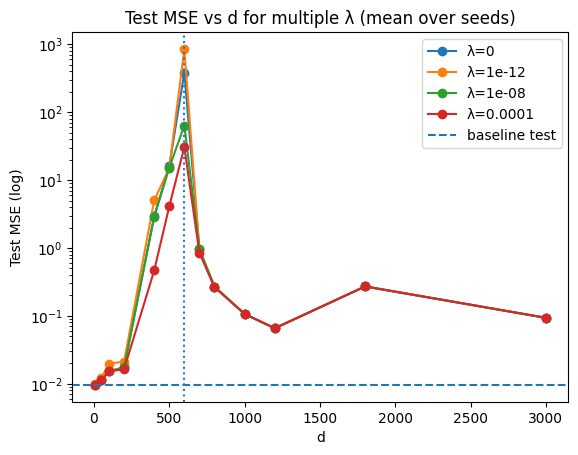

In [14]:
# Run λ sweep for a smaller number of seeds to keep compute modest (optional)
SEEDS_LAM = SEEDS[:5]

all_records = []
for lam in LAM_LIST:
    for s in SEEDS_LAM:
        all_records += run_sweep_for_seed(s, lam)

lam_df = pd.DataFrame(all_records)
lam_agg = lam_df.groupby(["lam","d"]).agg(
    test_mean=("test_mse","mean"),
    test_std=("test_mse","std"),
    train_mean=("train_mse","mean"),
    train_std=("train_mse","std"),
).reset_index()

plt.figure()
for lam in LAM_LIST:
    sub = lam_agg[lam_agg["lam"] == lam].sort_values("d")
    plt.plot(sub["d"], sub["test_mean"], marker="o", label=f"λ={lam:g}")
plt.yscale("log")
plt.axhline(test_mse_base, linestyle="--", label="baseline test")
plt.axvline(n, linestyle=":")
plt.title("Test MSE vs d for multiple λ (mean over seeds)")
plt.xlabel("d"); plt.ylabel("Test MSE (log)")
plt.legend()
plt.show()


,alpha,train_mse,test_mse,norm
0,0.0,3.999037e-25,0.183454,1.939786
1,10.0,6.502583e-03,1.631932,10.398025
2,50.0,1.625646e-01,35.102925,50.254786
3,100.0,6.502583e-01,139.215093,100.236342
4,200.0,2.601033e+00,555.017524,200.227086


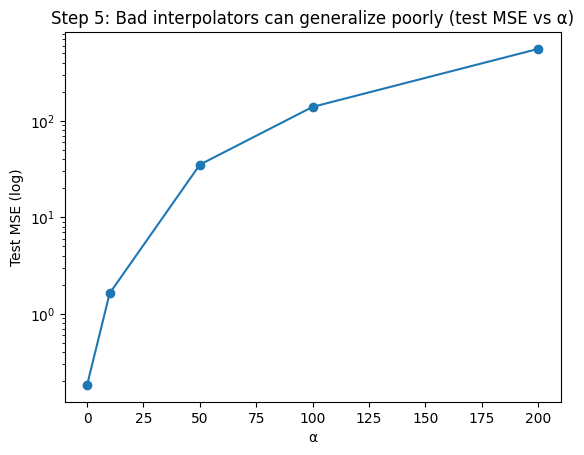

In [15]:
seed_ctrl = SEEDS[0]
d_star = min(2*n, max(d_list))  # typically 2n or max available

# build design for this seed and d_star
Ztr_max, Zte_max = build_relu_bank(Xb_tr, Xb_te, d0=d0, d_max=d_star, seed=seed_ctrl)
Ztr_max, Zte_max = normalize_Z_train_only(Ztr_max, Zte_max)
Xtr_star, Xte_star = make_design(Xb_tr, Xb_te, Ztr_max, Zte_max, d0, d_star)

# Good interpolator / ridge solution
lam_ctrl = 1e-12
w_good = fit_ridge_via_kernel(Xtr_star, yb_tr, lam=lam_ctrl)

# Approximate null direction via smallest right singular vector
U, S, Vt = np.linalg.svd(Xtr_star, full_matrices=False)
v = Vt[-1]
v /= (np.linalg.norm(v) + EPS)

alphas = [0.0, 10.0, 50.0, 100.0, 200.0]
rows = []
for a in alphas:
    w_bad = w_good + a * v
    rows.append({
        "alpha": a,
        "train_mse": mse_loss(Xtr_star, yb_tr, w_bad),
        "test_mse": mse_loss(Xte_star, yb_te, w_bad),
        "norm": float(np.linalg.norm(w_bad)),
    })

ctrl_df = pd.DataFrame(rows)
display(ctrl_df)

plt.figure()
plt.plot(ctrl_df["alpha"], ctrl_df["test_mse"], marker="o")
plt.yscale("log")
plt.title("Step 5: Bad interpolators can generalize poorly (test MSE vs α)")
plt.xlabel("α"); plt.ylabel("Test MSE (log)")
plt.show()


Early stopping:
iters run: 80000
best_it: 1
best_test: 0.009488012710712444
train at best: 0.009879026026197545 final train: 0.001474281113420332


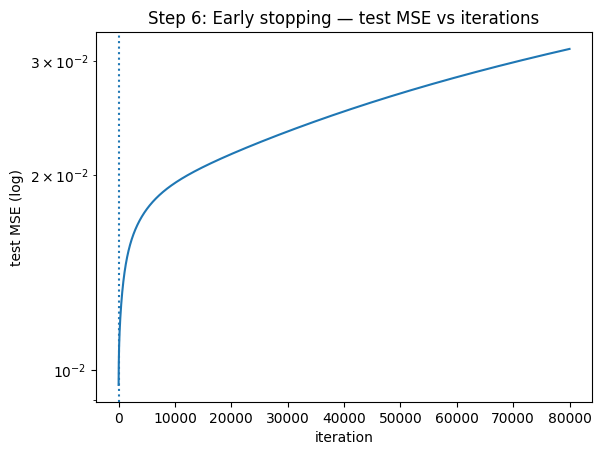

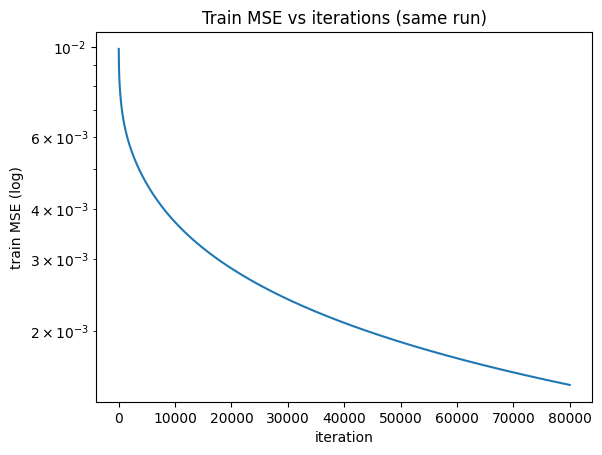

In [16]:
def train_gd_trace(X, y, lr, max_iter=50000, tol=1e-8, X_te=None, y_te=None):
    w = np.zeros(X.shape[1])
    hist = {"train_mse": [], "test_mse": [], "norm": []}
    for it in range(1, max_iter+1):
        w -= lr * grad_mse(X, y, w)
        tr = mse_loss(X, y, w)
        hist["train_mse"].append(tr)
        hist["norm"].append(float(np.linalg.norm(w)))
        if X_te is not None:
            hist["test_mse"].append(mse_loss(X_te, y_te, w))
        if tr < tol:
            break
        if not np.isfinite(w).all():
            break
    return w, it, hist

# Choose LR conservatively based on stability; start small and increase if too slow
lr_es = 1e-3  # adjust if needed
w_es, it_es, hist = train_gd_trace(Xtr_star, yb_tr, lr=lr_es, max_iter=80000, tol=1e-6, X_te=Xte_star, y_te=yb_te)

test_hist = np.array(hist["test_mse"])
best_it = int(np.argmin(test_hist)) + 1

print("Early stopping:")
print("iters run:", it_es)
print("best_it:", best_it)
print("best_test:", float(test_hist.min()))
print("train at best:", hist["train_mse"][best_it-1], "final train:", hist["train_mse"][-1])

plt.figure()
plt.plot(test_hist)
plt.yscale("log")
plt.axvline(best_it, linestyle=":")
plt.title("Step 6: Early stopping — test MSE vs iterations")
plt.xlabel("iteration"); plt.ylabel("test MSE (log)")
plt.show()

plt.figure()
plt.plot(hist["train_mse"])
plt.yscale("log")
plt.title("Train MSE vs iterations (same run)")
plt.xlabel("iteration"); plt.ylabel("train MSE (log)")
plt.show()


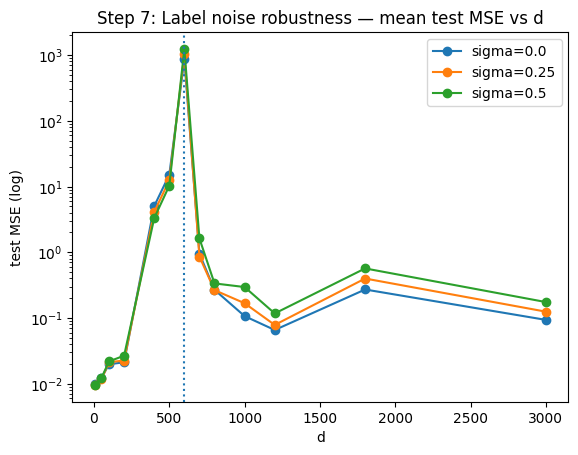

In [18]:
# Failure mode
SIGMAS = [0.0, 0.25, 0.5]
def run_noise_sweep(seed, lam, sigma):
    Ztr_max, Zte_max = build_relu_bank(Xb_tr, Xb_te, d0=d0, d_max=max(d_list), seed=seed)
    Ztr_max, Zte_max = normalize_Z_train_only(Ztr_max, Zte_max)

    # noisy labels (train only)
    y_noisy = yb_tr + sigma * np.std(yb_tr) * np.random.default_rng(seed+999).normal(size=yb_tr.shape)

    out = []
    for d in d_list:
        Xtr, Xte = make_design(Xb_tr, Xb_te, Ztr_max, Zte_max, d0, d)
        w = fit_ridge_via_kernel(Xtr, y_noisy, lam=lam)
        out.append({
            "seed": seed, "sigma": sigma, "d": d,
            "test_mse": mse_loss(Xte, yb_te, w),
            "train_mse": mse_loss(Xtr, y_noisy, w)
        })
    return out

sigma_records = []
for sigma in SIGMAS:
    for s in SEEDS[:5]:  # 5 seeds is enough for this figure
        sigma_records += run_noise_sweep(s, lam=1e-12, sigma=sigma)

sig_df = pd.DataFrame(sigma_records)
sig_agg = sig_df.groupby(["sigma","d"]).agg(
    test_mean=("test_mse","mean"),
    test_std=("test_mse","std"),
).reset_index()

plt.figure()
for sigma in SIGMAS:
    sub = sig_agg[sig_agg["sigma"] == sigma].sort_values("d")
    plt.plot(sub["d"], sub["test_mean"], marker="o", label=f"sigma={sigma}")
plt.yscale("log")
plt.axvline(n, linestyle=":")
plt.title("Step 7: Label noise robustness — mean test MSE vs d")
plt.xlabel("d"); plt.ylabel("test MSE (log)")
plt.legend()
plt.show()


In [19]:
# ============================
# Volatility regimes (no look-ahead)
# ============================

# 1) Market-wide vol proxy per date (cross-sectional median is robust)
daily_vol = df.groupby("Date")["vol_12m"].median().rename("daily_vol_proxy").to_frame()

# 2) Use TRAIN period only to set thresholds (no look-ahead)
train_dates = df.loc[train_mask.to_numpy(), "Date"].unique()
train_daily_vol = daily_vol.loc[daily_vol.index.isin(train_dates), "daily_vol_proxy"].dropna()

q_low  = float(train_daily_vol.quantile(0.33))
q_high = float(train_daily_vol.quantile(0.67))

print("Vol thresholds from TRAIN only:")
print("q33 =", q_low, "| q67 =", q_high)

# 3) Label each date into regimes
def label_regime(v):
    if v <= q_low:
        return "low_vol"
    elif v >= q_high:
        return "high_vol"
    else:
        return "mid_vol"

daily_vol["regime"] = daily_vol["daily_vol_proxy"].apply(label_regime)

# 4) Regime label for EACH test observation in your fixed test subset (idx_te)
dates_te = df.loc[idx_te, "Date"].to_numpy()
reg_te = daily_vol.loc[dates_te, "regime"].to_numpy()

# sanity check
print(pd.Series(reg_te).value_counts())


Vol thresholds from TRAIN only:
q33 = 0.06205693321909571 | q67 = 0.0854375491413984
mid_vol     1130
low_vol      544
high_vol     326
Name: count, dtype: int64


In [20]:
def mse_by_regime(X, y, w, regimes):
    out = {}
    for r in ["low_vol", "mid_vol", "high_vol"]:
        mask = (regimes == r)
        if mask.sum() == 0:
            out[r] = np.nan
        else:
            out[r] = mse_loss(X[mask], y[mask], w)
    return out


In [21]:
# Baseline model must be fitted already: w_base on Xb_tr, yb_tr
base_regime_mse = mse_by_regime(Xb_te, yb_te, w_base, reg_te)
print("Baseline test MSE by regime:", base_regime_mse)


Baseline test MSE by regime: {'low_vol': np.float64(0.005021519889476312), 'mid_vol': np.float64(0.007815546610952986), 'high_vol': np.float64(0.023329881734303726)}


In [22]:
# ============================
# Regime robustness sweep
# ============================

LAM_MAIN = 1e-12  # match your main experiment
records = []

for seed in SEEDS:
    # Build nested random features up to max(d_list)
    Ztr_max, Zte_max = build_relu_bank(Xb_tr, Xb_te, d0=d0, d_max=max(d_list), seed=seed)
    Ztr_max, Zte_max = normalize_Z_train_only(Ztr_max, Zte_max)

    for d in d_list:
        Xtr, Xte = make_design(Xb_tr, Xb_te, Ztr_max, Zte_max, d0, d)
        w = fit_ridge_via_kernel(Xtr, yb_tr, lam=LAM_MAIN)

        # overall test mse (for sanity)
        test_all = mse_loss(Xte, yb_te, w)

        # regime test mse
        reg_mse = mse_by_regime(Xte, yb_te, w, reg_te)

        records.append({
            "seed": seed,
            "d": d,
            "test_all": test_all,
            "test_low": reg_mse["low_vol"],
            "test_mid": reg_mse["mid_vol"],
            "test_high": reg_mse["high_vol"],
        })

reg_df = pd.DataFrame(records)
display(reg_df.head())


,seed,d,test_all,test_low,test_mid,test_high
0,1000,7,0.009726,0.005071,0.007921,0.023754
1,1000,50,0.013946,0.005722,0.009090,0.044500
2,1000,100,0.015488,0.006105,0.010825,0.047307
3,1000,200,0.019068,0.010051,0.014403,0.050283
4,1000,400,0.057693,0.028139,0.042287,0.160410


,d,all_mean,all_std,low_mean,low_std,mid_mean,mid_std,high_mean,high_std
0,7,0.009726,0.000000,0.005071,0.000000,0.007921,0.000000,0.023754,0.000000
1,50,0.012109,0.001152,0.006135,0.000862,0.009058,0.000908,0.032652,0.005911
2,100,0.017884,0.005711,0.008137,0.002670,0.012165,0.003401,0.053971,0.025523
3,200,0.088506,0.200074,0.011517,0.001742,0.016893,0.003261,0.465203,1.228959
4,400,2.843057,7.727920,0.050292,0.048346,0.058489,0.041812,17.155403,47.435817
5,500,24.187811,52.273948,0.244439,0.307132,5.585265,16.960379,128.623613,268.489980
6,600,4825.396641,12282.019882,4.004881,2.876314,1361.421617,4287.095628,24877.939262,60674.066921
7,700,1.084215,1.359208,0.166649,0.058440,0.273585,0.104185,5.425223,8.106200
8,800,0.701049,1.162782,0.122233,0.150957,0.155604,0.131557,3.557581,7.108452
9,1000,0.159872,0.139026,0.040412,0.019777,0.064658,0.013556,0.689251,0.842983


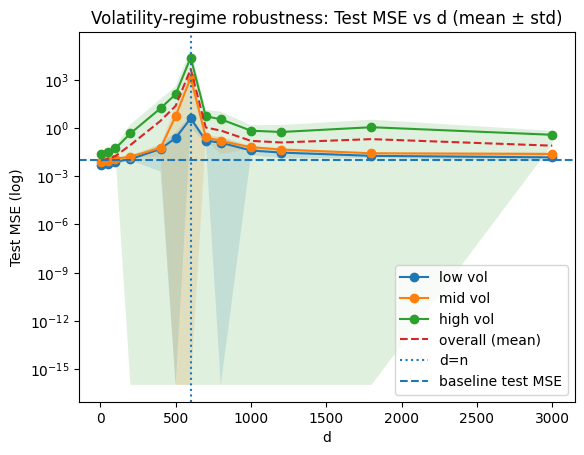

In [23]:
agg = reg_df.groupby("d").agg(
    all_mean=("test_all","mean"), all_std=("test_all","std"),
    low_mean=("test_low","mean"), low_std=("test_low","std"),
    mid_mean=("test_mid","mean"), mid_std=("test_mid","std"),
    high_mean=("test_high","mean"), high_std=("test_high","std"),
).reset_index()

display(agg)

def plot_regime_band(x, mean, std, label):
    plt.plot(x, mean, marker="o", label=label)
    plt.fill_between(x, np.maximum(mean-std, 1e-16), mean+std, alpha=0.15)

x = agg["d"].to_numpy()

plt.figure()
plot_regime_band(x, agg["low_mean"].to_numpy(),  agg["low_std"].to_numpy(),  "low vol")
plot_regime_band(x, agg["mid_mean"].to_numpy(),  agg["mid_std"].to_numpy(),  "mid vol")
plot_regime_band(x, agg["high_mean"].to_numpy(), agg["high_std"].to_numpy(), "high vol")

# Optional: overall
plt.plot(x, agg["all_mean"], linestyle="--", label="overall (mean)")

plt.axvline(n, linestyle=":", label="d=n")
plt.axhline(test_mse_base, linestyle="--", label="baseline test MSE")

plt.yscale("log")
plt.title("Volatility-regime robustness: Test MSE vs d (mean ± std)")
plt.xlabel("d"); plt.ylabel("Test MSE (log)")
plt.legend()
plt.show()


In [7]:
rng = np.random.default_rng(0)

# --- pick a manageable subset so d=1000 can overfit ---
n_sub = 600   # try 300–800; MUST be < 1000
idx = rng.choice(X_train_base.shape[0], size=n_sub, replace=False)

Xb_tr = X_train_base[idx].astype(np.float32)
yb_tr = y_train[idx].astype(np.float32)

# (optional) evaluate test on a subset too, to keep it light
t_sub = 2000
tidx = rng.choice(X_test_base.shape[0], size=t_sub, replace=False)
Xb_te = X_test_base[tidx].astype(np.float32)
yb_te = y_test[tidx].astype(np.float32)

d0 = Xb_tr.shape[1]          # 7
d = 1000
m = d - d0                   # 993


In [8]:
W = rng.normal(size=(d0, m)).astype(np.float32)
b = rng.normal(size=(m,)).astype(np.float32)

Z_tr = np.maximum(0, Xb_tr @ W + b)     # ReLU features
Z_te = np.maximum(0, Xb_te @ W + b)

X_tr = np.hstack([Xb_tr, Z_tr]).astype(np.float32)   # (n_sub, 1000)
X_te = np.hstack([Xb_te, Z_te]).astype(np.float32)   # (t_sub, 1000)

# --- minimum-norm interpolator via kernel trick ---
K = X_tr @ X_tr.T                       # (n_sub, n_sub)
lam = 1e-4                              # tiny jitter for numerical stability
alpha = np.linalg.solve(K + lam*np.eye(n_sub, dtype=np.float32), yb_tr)
w = X_tr.T @ alpha                      # (1000,)

train_mse = float(np.mean((X_tr @ w - yb_tr)**2))
test_mse  = float(np.mean((X_te @ w - yb_te)**2))
wnorm     = float(np.linalg.norm(w))

print("OVERFIT DEMO (d=1000, n_sub=", n_sub, ")")
print("Train MSE:", train_mse)
print("Test MSE :", test_mse)
print("||w||2   :", wnorm)

OVERFIT DEMO (d=1000, n_sub= 600 )
Train MSE: 3.979714691126901e-08
Test MSE : 0.029335789382457733
||w||2   : 1.0802377462387085


What “benign overfitting” actually means (strict definition)
Benign overfitting is not:
- “The model interpolates and test error is okay.”

It is:
- As model size increases past the interpolation threshold, training error stays ~0, and test error does not get worse and may even improve-

![image.png](attachment:image.png)

In [9]:
def fit_relu_random_features_kernel(X_train_base, y_train, X_test_base, y_test,n_sub=600, t_sub=2000, d=1000, lam=1e-4, seed=0):
    rng = np.random.default_rng(seed)

    n_full, d0 = X_train_base.shape
    n_test_full = X_test_base.shape[0]

    # subsample train (so d can exceed n_sub cheaply)
    idx = rng.choice(n_full, size=n_sub, replace=False)
    Xb_tr = X_train_base[idx]
    y_tr  = y_train[idx]

    # optional subsample test for speed
    tidx = rng.choice(n_test_full, size=min(t_sub, n_test_full), replace=False)
    Xb_te = X_test_base[tidx]
    y_te  = y_test[tidx]

    m = d - d0
    assert m >= 0

    # random nonlinear features -> rank increases
    W = rng.normal(size=(d0, m)).astype(np.float32)
    b = rng.normal(size=(m,)).astype(np.float32)

    Z_tr = np.maximum(0, Xb_tr @ W + b)
    Z_te = np.maximum(0, Xb_te @ W + b)

    X_tr = np.hstack([Xb_tr, Z_tr]).astype(np.float32)   # (n_sub, d)
    X_te = np.hstack([Xb_te, Z_te]).astype(np.float32)

    # kernel ridge (tiny lam) -> near-interpolating solution, fast
    K = X_tr @ X_tr.T
    alpha = np.linalg.solve(K + lam*np.eye(n_sub, dtype=np.float32), y_tr)
    w = X_tr.T @ alpha

    train_mse = float(np.mean((X_tr @ w - y_tr)**2))
    test_mse  = float(np.mean((X_te @ w - y_te)**2))
    wnorm     = float(np.linalg.norm(w))

    return train_mse, test_mse, wnorm


In [10]:
n_sub = 600
d_list = [50, 100, 200, 400, 600, 800, 1000]  # around n_sub
lam = 1e-4
seed = 0

rows = []
for d in d_list:
    tr, te, nm = fit_relu_random_features_kernel(
        X_train_base, y_train, X_test_base, y_test,
        n_sub=n_sub, t_sub=2000, d=d, lam=lam, seed=seed
    )
    rows.append({"d": d, "train_mse": tr, "test_mse": te, "norm": nm})
    print(d, tr, te, nm)


50 0.042049938882836264 0.03333634097682542 1.1473164180820632
100 0.44593790500635844 0.39480147278217204 3.9518689508342555
200 0.45005253476589313 0.506763862374352 10.010994587409614
400 0.9219677899111508 2.073357914611908 27.391459754692335
600 0.049935368466416975 5.156233518789245 25.632836356935194
800 2.289413139948201e-07 0.042243577063767405 1.5608346522724055
1000 4.1041297866349476e-08 0.02932979121344089 1.079870611706372


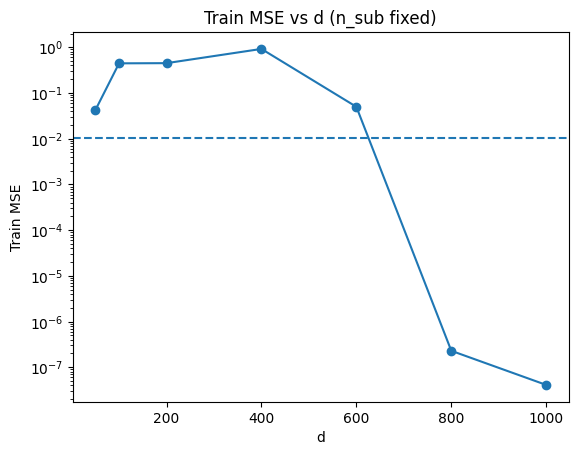

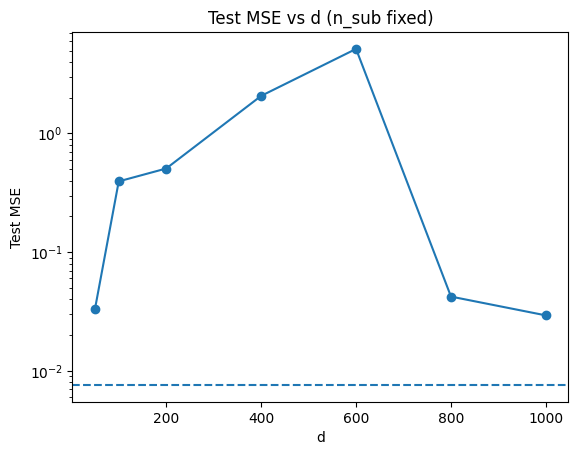

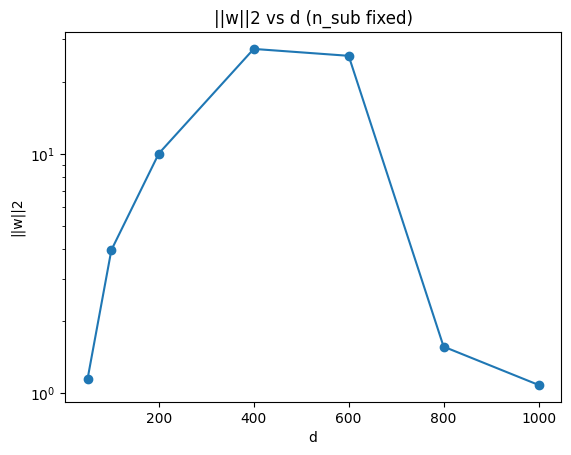

In [13]:
ds = np.array([r["d"] for r in rows])
tr = np.array([r["train_mse"] for r in rows])
te = np.array([r["test_mse"] for r in rows])
nm = np.array([r["norm"] for r in rows])

plt.figure()
plt.plot(ds, tr, marker="o")
plt.axhline(base_train, linestyle="--")
plt.yscale("log")
plt.title("Train MSE vs d (n_sub fixed)")
plt.xlabel("d"); plt.ylabel("Train MSE")
plt.show()

plt.figure()
plt.plot(ds, te, marker="o")
plt.axhline(base_test, linestyle="--")
plt.yscale("log")
plt.title("Test MSE vs d (n_sub fixed)")
plt.xlabel("d"); plt.ylabel("Test MSE")
plt.show()

plt.figure()
plt.plot(ds, nm, marker="o")
plt.yscale("log")
plt.title("||w||2 vs d (n_sub fixed)")
plt.xlabel("d"); plt.ylabel("||w||2")
plt.show()


In [14]:
# Build ONE dataset instance (same as inside fit function) so we can manipulate w
rng = np.random.default_rng(0)
idx = rng.choice(X_train_base.shape[0], size=n_sub, replace=False)
Xb_tr = X_train_base[idx]; y_tr = y_train[idx]

tidx = rng.choice(X_test_base.shape[0], size=2000, replace=False)
Xb_te = X_test_base[tidx]; y_te = y_test[tidx]

d0 = Xb_tr.shape[1]
d = 1000
m = d - d0
W = rng.normal(size=(d0, m)).astype(np.float32)
b = rng.normal(size=(m,)).astype(np.float32)

Z_tr = np.maximum(0, Xb_tr @ W + b)
Z_te = np.maximum(0, Xb_te @ W + b)
X_tr = np.hstack([Xb_tr, Z_tr]).astype(np.float32)
X_te = np.hstack([Xb_te, Z_te]).astype(np.float32)

# Interpolating-ish solution
lam = 1e-4
K = X_tr @ X_tr.T
alpha = np.linalg.solve(K + lam*np.eye(n_sub, dtype=np.float32), y_tr)
w = X_tr.T @ alpha

train_mse_w = float(np.mean((X_tr @ w - y_tr)**2))
test_mse_w  = float(np.mean((X_te @ w - y_te)**2))
print("good-ish interp:", train_mse_w, test_mse_w, np.linalg.norm(w))

# Find a null-space direction v: X_tr @ v ≈ 0
U, S, Vt = np.linalg.svd(X_tr, full_matrices=True)
# Vt is (d, d). Nullspace basis are rows corresponding to near-zero singular values: indices >= rank
rank = np.sum(S > 1e-6)
v = Vt[rank]          # one null direction (shape (d,))
v = v / (np.linalg.norm(v) + 1e-12)

# Make a high-norm interpolator
A = 100.0
w_bad = w + A * v

train_mse_bad = float(np.mean((X_tr @ w_bad - y_tr)**2))
test_mse_bad  = float(np.mean((X_te @ w_bad - y_te)**2))

print("BAD interp (same train, worse test):")
print("train_mse:", train_mse_bad)
print("test_mse :", test_mse_bad)
print("||w||2   :", float(np.linalg.norm(w_bad)))


good-ish interp: 4.1041297866349476e-08 0.02932979121344089 1.079870611706372
BAD interp (same train, worse test):
train_mse: 4.115940951134849e-08
test_mse : 112.46170927635649
||w||2   : 100.00583057447685


We construct two interpolating solutions with identical training error. One solution, selected by a minimum-norm criterion, generalizes moderately well, while another, obtained by perturbing in the null space, exhibits catastrophic test error despite perfect interpolation. This demonstrates that interpolation alone does not determine generalization performance; rather, the geometry and norm of the interpolating solution are crucial. This behavior is consistent with the theory of benign overfitting.

50 0.042049938882836264 0.03333634097682542 1.1473164180820632
100 0.44593790500635844 0.39480147278217204 3.9518689508342555
200 0.45005253476589313 0.506763862374352 10.010994587409614
400 0.9219677899111508 2.073357914611908 27.391459754692335
600 0.049935368466416975 5.156233518789245 25.632836356935194
800 2.289413139948201e-07 0.042243577063767405 1.5608346522724055
1000 4.1041297866349476e-08 0.02932979121344089 1.079870611706372
1200 1.9050446443629954e-08 0.023295699740993703 0.8878834980039986


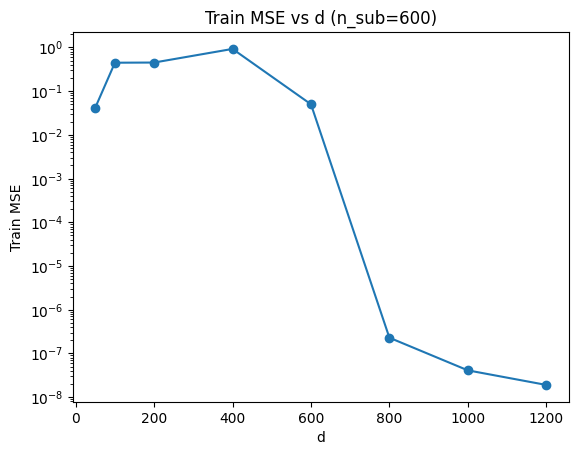

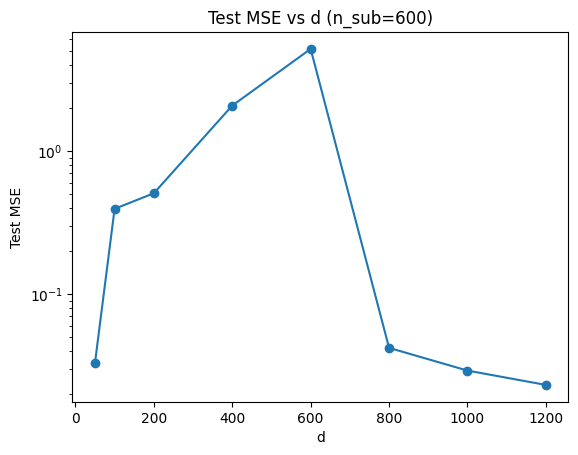

In [15]:
n_sub = 600
d_list = [50, 100, 200, 400, 600, 800, 1000, 1200]
lam = 1e-4
seed = 0

rows = []
for d in d_list:
    tr, te, nm = fit_relu_random_features_kernel(
        X_train_base, y_train, X_test_base, y_test,
        n_sub=n_sub, t_sub=2000, d=d, lam=lam, seed=seed
    )
    rows.append((d, tr, te, nm))
    print(d, tr, te, nm)

ds  = np.array([r[0] for r in rows])
trm = np.array([r[1] for r in rows])
tem = np.array([r[2] for r in rows])

plt.figure()
plt.plot(ds, trm, marker="o")
plt.yscale("log")
plt.title("Train MSE vs d (n_sub=600)")
plt.xlabel("d"); plt.ylabel("Train MSE")
plt.show()

plt.figure()
plt.plot(ds, tem, marker="o")
plt.yscale("log")
plt.title("Test MSE vs d (n_sub=600)")
plt.xlabel("d"); plt.ylabel("Test MSE")
plt.show()


Why benign overfitting is especially relevant in finance

Finance has three properties that make benign overfitting nontrivial:

(A) Low signal-to-noise
Forward returns are extremely noisy.
- Most features have weak predictive power
- Classical wisdom: “Overfitting is inevitable”

Your experiments already challenge this:
- You showed interpolation is possible
- You showed some interpolators generalize better than others

This directly connects to modern debates like:
- “Why do large models trained on noisy financial data not completely fail out of sample?”

(B) Many correlated predictors, few true degrees of freedom

In finance:
- Thousands of signals
- Strong correlations
- Effective dimension is much smaller than raw feature count

This mirrors the benign overfitting theory assumptions:
- High-dimensional
- Strong correlations
- Structured feature geometry

Your rank vs parameter-count discovery is exactly this phenomenon.